# COVID-19 Open Research Dataset Analysis

### Dataset Information

The CORD-19 dataset is an open-access collection of scientific publications related to the **COVID-19 pandemic**, published by the **Allen Institute for AI**. It contains **over one million records**.

The `metadata.csv` file provides essential **article metadata**, including **title**, **abstract**, **authors**, and **publication date**. In this study, the dataset was loaded, its structure inspected, and prepared for exploratory data analysis.

### Key Metadata Fields

- **cord_uid**: Unique article identifier
- **title**: Article title
- **abstract**: Abstract text
- **authors**: List of authors
- **journal**: Publishing journal
- **publish_time**: Publication date
- **doi / pmcid / pubmed_id / arxiv_id**: External identifiers
- **license**: Publication license
- **source_x**: Data sources (e.g., ArXiv, PMC, WHO)
- **url**: Article URLs
- **pdf_json_files / pmc_json_files**: Parsed full-text file paths
- **s2_id**: Semantic Scholar ID

### Key Outputs

- 20 Labeled Research Topics - Interpretable themes in COVID-19 research
- Word Cloud Visualizations - Visual representation of topic keywords
- Historical Trend Chart - Topic evolution from 1970-2020
- Representative Papers - Concrete examples for each topic

## 1. Setup & Data Loading

In [14]:
!pip install langdetect

  Using cached langdetect-1.0.9.tar.gz (981 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993363 sha256=74c2480a7bcbd95413fedb5594f46511c77a02acf419bfe967d57173b9ed5509
  Stored in directory: c:\users\zhang\appdata\local\pip\cache\wheels\0a\f2\b2\e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [15]:
!pip install sentence-transformers

  Using cached sentence_transformers-5.2.0-py3-none-any.whl.metadata (16 kB)
  Using cached transformers-4.57.3-py3-none-any.whl.metadata (43 kB)
  Using cached huggingface_hub-0.36.0-py3-none-any.whl.metadata (14 kB)
  Using cached tokenizers-0.22.1-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
Using cached sentence_transformers-5.2.0-py3-none-any.whl (493 kB)
Using cached transformers-4.57.3-py3-none-any.whl (12.0 MB)
Using cached huggingface_hub-0.36.0-py3-none-any.whl (566 kB)
Using cached tokenizers-0.22.1-cp39-abi3-win_amd64.whl (2.7 MB)
   ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
   ---------------------------------------- 6.2/6.2 MB 34.5 MB/s  0:00:00

  Attempting uninstall: sympy

    Found existing installation: sympy 1.14.0

   ---- ----------------------------------- 1/9 [sympy]
   ---- ----------------------------------- 1/9 [sympy]
   ---- ----------------------------------- 1/9 [sympy]
   ---- ----------------------------------- 1/9 [sympy]
    Unin

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from langdetect import detect, DetectorFactory, LangDetectException
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import matplotlib.cm as cm
import os
import re

In [2]:
df = pd.read_csv("metadata.csv")

C:\Users\zhang\AppData\Local\Temp\ipykernel_20020\195187386.py:1: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("metadata.csv")


## 2. Exploratory Data Analysis (EDA)

In [3]:
df.head(5) 

cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   
2    Surfactant protein-D and pulmonary host defense           10.1186/rr19   
3               Role of endothelin-1 in lung disease           10.1186/rr44   
4  Gene expression in epithelial cells in respons...           10.1186/rr61   

      pmcid pubmed_id license  \
0  PMC35282  11472636   no-cc   
1  PMC59543  11667967   no-cc   
2  PMC59549  11667972   no-cc   
3  PMC59574  11686871   no-cc   
4  PMC59580  11686888   no-cc   

                                            abstract publish_time  \
0  OBJECTIVE: This retrospective chart review des...   2001-07-04   
1  Inflammatory diseases of the respiratory tract...   2000-08-15   
2  Surfactant protein-D (SP-D) participates in th...   2000-08-25   
3  Endothelin-1 (ET-1) is a 21 amino acid peptide...   2001-02-22   
4  Respiratory syncytial virus (RSV) and pneumoni...   2001-05-11   

                                             authors         journal  mag_id  \
0                Madani, Tariq A; Al-Ghamdi, Aisha A  BMC Infect Dis     NaN   
1  Vliet, Albert van der; Eiserich, Jason P; Cros...      Respir Res     NaN   
2                                    Crouch, Erika C      Respir Res     NaN   
3  Fagan, Karen A; McMurtry, Ivan F; Rodman, David M      Respir Res     NaN   
4  Domachowske, Joseph B; Bonville, Cynthia A; Ro...      Respir Res     NaN   

  who_covidence_id arxiv_id  \
0              NaN      NaN   
1              NaN      NaN   
2              NaN      NaN   
3              NaN      NaN   
4              NaN      NaN   

                                      pdf_json_files  \
0  document_parses/pdf_json/d1aafb70c066a2068b027...   
1  document_parses/pdf_json/6b0567729c2143a66d737...   
2  document_parses/pdf_json/06ced00a5fc04215949aa...   
3  document_parses/pdf_json/348055649b6b8cf2b9a37...   
4  document_parses/pdf_json/5f48792a5fa08bed9f560...   

                               pmc_json_files  \
0  document_parses/pmc_json/PMC35282.xml.json   
1  document_parses/pmc_json/PMC59543.xml.json   
2  document_parses/pmc_json/PMC59549.xml.json   
3  document_parses/pmc_json/PMC59574.xml.json   
4  document_parses/pmc_json/PMC59580.xml.json   

                                                 url  s2_id  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...    NaN  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
3  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
4  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056660 entries, 0 to 1056659
Data columns (total 19 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   cord_uid          1056660 non-null  object 
 1   sha               373766 non-null   object 
 2   source_x          1056660 non-null  object 
 3   title             1056157 non-null  object 
 4   doi               656780 non-null   object 
 5   pmcid             389571 non-null   object 
 6   pubmed_id         498932 non-null   object 
 7   license           1056660 non-null  object 
 8   abstract          821116 non-null   object 
 9   publish_time      1054846 non-null  object 
 10  authors           1032791 non-null  object 
 11  journal           969338 non-null   object 
 12  mag_id            0 non-null        float64
 13  who_covidence_id  482935 non-null   object 
 14  arxiv_id          14249 non-null    object 
 15  pdf_json_files    373766 non-null   object 
 16  

In [5]:
df.shape

(1056660, 19)

In [6]:
df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')
df['year'] = df['publish_time'].dt.year.astype('Int64')
df['month'] = df['publish_time'].dt.month.astype('Int64')
print(f"The most frequent year: {df['year'].mode().iloc[0]}")
print(f"The most frequent month: {df['month'].mode().iloc[0]}")

The most frequent year: 2021
The most frequent month: 5


In [7]:
df['author_count'] = df['authors'].astype('str').apply(lambda x: len(x.split(';')) if x != 'nan' else 0)
print(f"The average number of authors: {df['author_count'].mean().round()}")

The average number of authors: 6.0


In [8]:
df['abstract_length'] = df['abstract'].astype(str).apply(len)
print(f"The average length of abstract: {df['abstract_length'].mean().round()} characters")

The average length of abstract: 1136.0 characters


In [9]:
## Missing Value Analysis
missing_values = df.isnull().sum().sort_values(ascending=False).head(10)
missing_percent = (missing_values / len(df)) * 100

missing_data = pd.DataFrame({
    'Missing Values': missing_values,
    'Missing (%)': missing_percent
})
missing_data

Missing Values  Missing (%)
mag_id                   1056660   100.000000
arxiv_id                 1042411    98.651506
pmc_json_files            740918    70.118865
pdf_json_files            682894    64.627600
sha                       682894    64.627600
pmcid                     667089    63.131849
who_covidence_id          573725    54.296084
pubmed_id                 557728    52.782163
publish_time              537789    50.895179
month                     537789    50.895179

In [10]:
## Feature Engineering
# For an article must have it's unique cord_uid, title authors and abstract
must_have_cols = [
    'cord_uid',
    'title',
    'authors',
    'abstract'
]
df_clean = df.dropna(subset=must_have_cols)
# Abstract usually is longer than 50 characters
df_clean = df_clean[df_clean['abstract'].str.len() > 50]
# Number of authors is usually between 1-100
df_clean = df_clean[df_clean['author_count'].between(1, 100)]
print(f"Original rows: {len(df)}")
print(f"Remaining rows: {len(df_clean)}")

Original rows: 1056660
Remaining rows: 814007


In [17]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 814007 entries, 0 to 1056659
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   cord_uid          814007 non-null  object        
 1   sha               325243 non-null  object        
 2   source_x          814007 non-null  object        
 3   title             814007 non-null  object        
 4   doi               530550 non-null  object        
 5   pmcid             309878 non-null  object        
 6   pubmed_id         401256 non-null  object        
 7   license           814007 non-null  object        
 8   abstract          814007 non-null  object        
 9   publish_time      412204 non-null  datetime64[ns]
 10  authors           814007 non-null  object        
 11  journal           735556 non-null  object        
 12  mag_id            0 non-null       float64       
 13  who_covidence_id  355837 non-null  object        
 14  arxiv_id

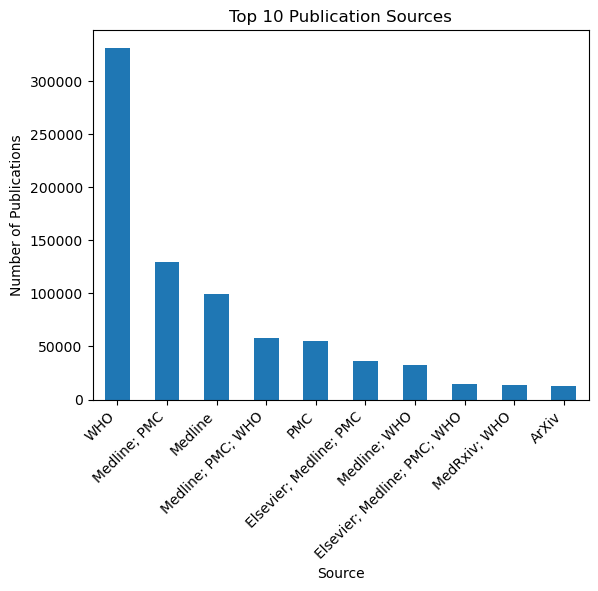

In [20]:
df_clean['source_x'].value_counts().head(10).plot(kind = 'bar')
plt.title("Top 10 Publication Sources")
plt.xlabel("Source")
plt.ylabel("Number of Publications")
plt.xticks(rotation=45, ha='right')
plt.show()

The graph shows distribution of publication sources in the dataset. The majority of records originate from **WHO** documents and biomedical literature indexed in **Medline** and **PubMed Central (PMC)**. Additional contributions come from commercial publishers such as **Elsevier** and from preprint platforms including **medRxiv** and **arXiv**, reflecting a mix of peer-reviewed, open-access, and preprint research.

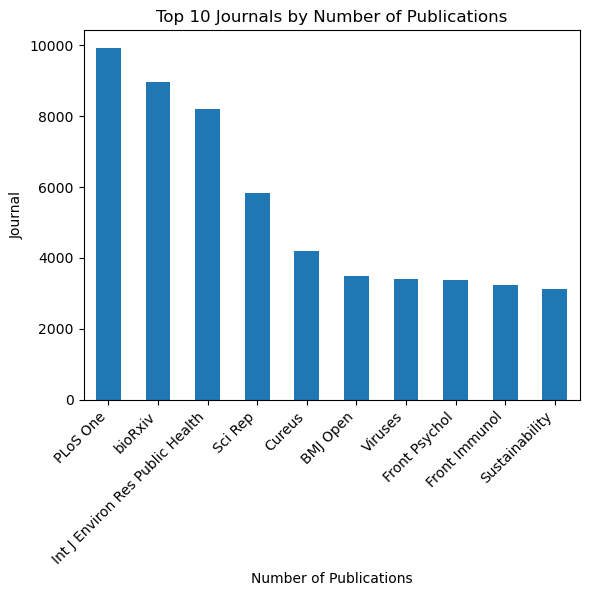

In [12]:
top_journals = df_clean['journal'].value_counts().head(10)
top_journals.plot(kind = 'bar')
plt.title("Top 10 Journals by Number of Publications")
plt.xlabel("Number of Publications")
plt.ylabel("Journal")
plt.xticks(rotation=45, ha='right')
plt.show()

The figure shows that **PLoS One**, **bioRxiv**, and **International Journal of Environmental Research and Public Health** dominate the dataset, each contributing nearly twice as many articles as other journals in the top ranks. bioRxiv is a life-sciences preprint platform where manuscripts are shared before peer review to enable rapid dissemination.

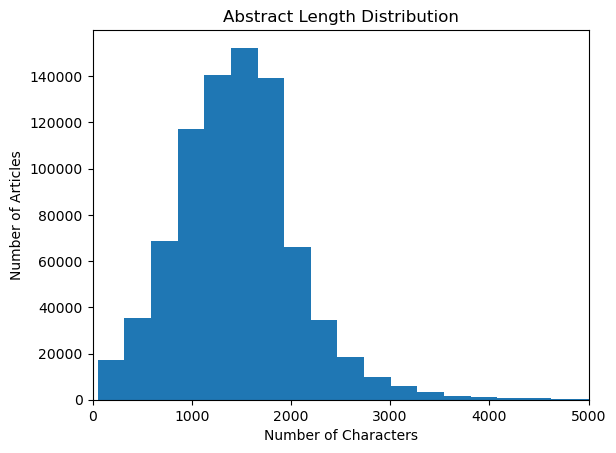

In [13]:
plt.hist(df_clean['abstract_length'], bins=100)
plt.title("Abstract Length Distribution")
plt.xlabel("Number of Characters")
plt.ylabel("Number of Articles")
plt.xlim(0, 5000)
plt.show()

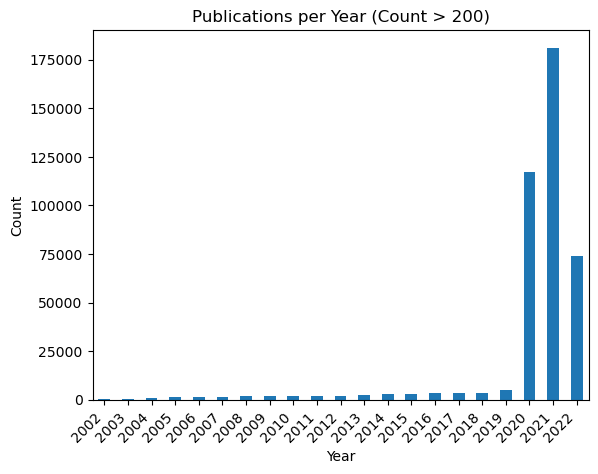

In [14]:
year_counts = df_clean['year'].value_counts()
year_counts = year_counts[year_counts > 200].sort_index()

year_counts.plot(kind='bar')
plt.xticks(rotation=45, ha='right')
plt.title('Publications per Year (Count > 200)')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

Starting from **2002**, each year contributes more than 200 publications to the COVID-19 Open Research Dataset. A clear increase appears from **2020** onward, corresponding to the global outbreak of COVID-19 and the subsequent rise in research output.

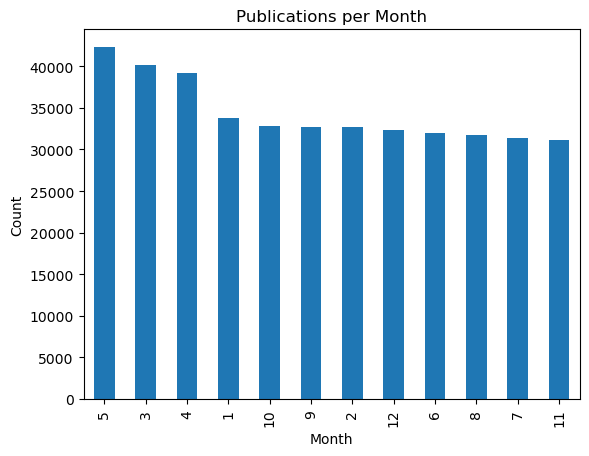

In [21]:
month_counts = df_clean['month'].value_counts()
month_counts.plot(kind='bar')
plt.title('Publications per Month')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

**Spring** months (March, April, and May) show the highest publication volume, with around 40,000 publications, exceeding the counts observed in other months. The higher number of publications in spring may be due to common academic publishing schedules, where many studies are completed and released after winter. In addition, the rapid increase in COVID-19 research likely contributed to more publications during this period.

In [28]:
df_clean['author_list'] = (
    df_clean['authors']
    .astype(str)
    .str.split("; ")
)

In [30]:
authors_exploded = df_clean.explode("author_list")

authors_exploded["author_list"] = (
    authors_exploded["author_list"]
    .str.strip()
)

<Axes: title={'center': 'Top 20 Most Published Authors'}, ylabel='author_list'>

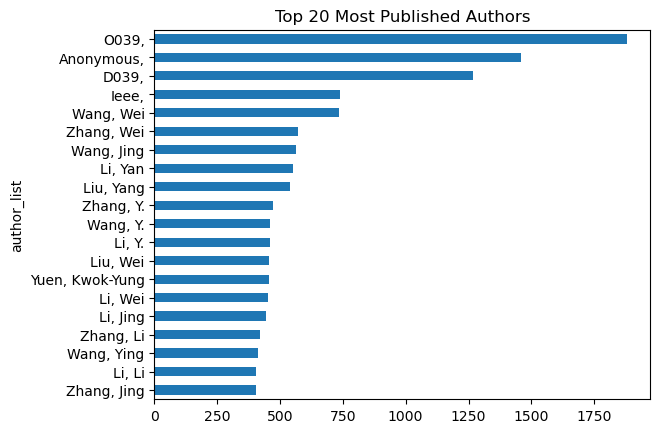

In [37]:
top20_authors = (
    authors_exploded["author_list"]
    .value_counts()
    .head(20)
)

top20_authors.sort_values().plot(kind="barh", title="Top 20 Most Published Authors")

The four most frequently listed author names in the dataset are O039, Anonymous, D039, and leee, which likely reflect records without clearly identifiable author information. The rest of the following top 20 authors have Chinese-sounding names and are associated with more than 370 articles each, which may be influenced by both the high research output from China and the presence of common author names shared by multiple individuals.

## 4. Data Preprocessing

In [42]:
tqdm.pandas()
def detect_lang_safe(text):
    try:
        return detect(text)
    except LangDetectException:
        return None
df_clean["language"] = df_clean["abstract"].str[:300].progress_apply(detect_lang_safe)

100%|█████████████████████████████████████████████████████████████████████████| 814007/814007 [37:42<00:00, 359.79it/s]


In [53]:
df_clean["language"].value_counts().head(10)

language
en       801786
es         3094
pt         2635
fr         2174
id         1713
de         1345
nl          329
zh-cn       249
tr          167
hu          167
Name: count, dtype: int64

In [45]:
nlp_df = df_clean[["title", "abstract", "year", "journal", "abstract_length", "language"]]
nlp_en = nlp_df[nlp_df["language"] == "en"].copy()

In [46]:
nlp_en.head(5)

title  \
0  Clinical features of culture-proven Mycoplasma...   
1  Nitric oxide: a pro-inflammatory mediator in l...   
2    Surfactant protein-D and pulmonary host defense   
3               Role of endothelin-1 in lung disease   
4  Gene expression in epithelial cells in respons...   

                                            abstract  year         journal  \
0  OBJECTIVE: This retrospective chart review des...  2001  BMC Infect Dis   
1  Inflammatory diseases of the respiratory tract...  2000      Respir Res   
2  Surfactant protein-D (SP-D) participates in th...  2000      Respir Res   
3  Endothelin-1 (ET-1) is a 21 amino acid peptide...  2001      Respir Res   
4  Respiratory syncytial virus (RSV) and pneumoni...  2001      Respir Res   

   abstract_length language  
0             1847       en  
1             1001       en  
2             1647       en  
3              418       en  
4              834       en

In [52]:
print(f'the earliest publication year in the dataset is {nlp_en["year"].min()}.')

the earliest publication year in the dataset is 1955.


In [54]:
nlp_en["text"] = nlp_en["title"] + ". " + nlp_en["abstract"]
nlp_en.to_csv("nlp_en_with_language.csv", index=False)

## 5. SBERT Embedding

In [32]:
# Read dataset only with abstract in English
nlp_en = pd.read_csv("nlp_en_with_language.csv")

In [17]:
# Loading SBERT model
model = SentenceTransformer("all-MiniLM-L6-v2", device="cuda")

In [19]:
# Save the embeddings
embeddings = model.encode(
    nlp_en["text"].tolist(),
    batch_size=32,
    show_progress_bar=True
)
np.save("embeddings.npy", embeddings)

Batches:   0%|          | 0/25056 [00:00<?, ?it/s]

## 6. Topic Clustering

In [3]:
# Performing PCA before topic clustering
embeddings = np.load("embeddings.npy")
pca = PCA(
    n_components=0.7,
    random_state=42
)
embeddings_pca = pca.fit_transform(embeddings)
print(f"Before PCA has {embeddings.shape[1]} demensions, after PCA covering 70% variance {embeddings_pca.shape[1]}.")

Before PCA has 384 demensions, after PCA covering 70% variance 78.


In [4]:
# To reduce the looping time, we random sellect 100,000 data points as sample
X = embeddings_pca 
rng = np.random.default_rng(42)
idx = rng.choice(X.shape[0], size=100_000, replace=False)
X_sample = X[idx]

In [7]:
# Select number of k for minibatchkmeans
ks = [10, 20, 30, 40, 50, 100]

results = []

for k in ks:
    km = MiniBatchKMeans(
        n_clusters=k,
        batch_size=10_000,
        random_state=42,
        n_init="auto"
    )
    labels = km.fit_predict(X_sample)

    inertia = km.inertia_
    ch = calinski_harabasz_score(X_sample, labels)
    db = davies_bouldin_score(X_sample, labels)

    sub_idx = rng.choice(X_sample.shape[0], size=20_000, replace=False)
    sil = silhouette_score(X_sample[sub_idx], labels[sub_idx], metric="euclidean")

    results.append((k, round(inertia,3), round(sil,3), round(ch,3), round(db,3)))

In [8]:
df_scores = pd.DataFrame(results,columns=["k","inertia","silhouette","calinski_harabasz","davies_bouldin"])
df_scores

k    inertia  silhouette  calinski_harabasz  davies_bouldin
0   10  44871.699       0.047           3287.103           3.315
1   20  41719.203       0.049           2077.393           3.220
2   30  39644.516       0.045           1613.980           3.234
3   40  38163.688       0.047           1345.532           3.133
4   50  37166.695       0.046           1153.189           3.082
5  100  34157.684       0.043            710.076           3.080

To select an appropriate **number of clusters (k)** for **MiniBatchKMeans**, **inertia** shows how compact clusters are (lower is better), **Silhouette Score**: how well-separated clusters are (higher is better), **Calinski–Harabasz Index**: Ratio of between-cluster dispersion to within-cluster dispersion (higher is better). **Davies–Bouldin Index**: Average similarity between each cluster and its most similar cluster (lower is better). With a trade-off of relative higher silhouette score and lower davies_boundin, I choose k=20.

In [33]:
best_k = 20

kmeans = MiniBatchKMeans(
    n_clusters=best_k,
    batch_size=50_000,
    random_state=42,
    n_init="auto"
)

nlp_en["topic"] = kmeans.fit_predict(embeddings_pca)

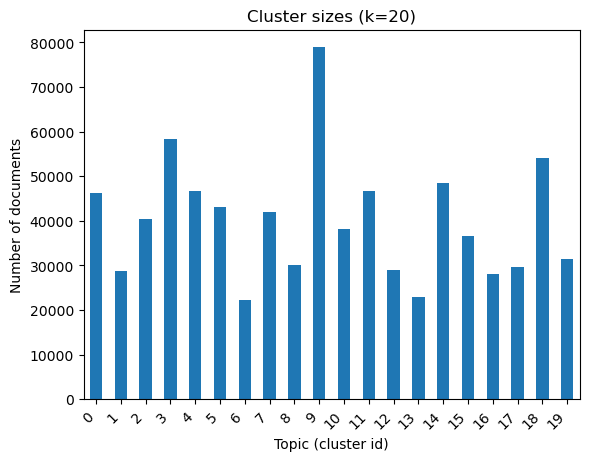

In [34]:
counts = nlp_en["topic"].value_counts().sort_index()
counts.plot(kind="bar")
plt.xlabel("Topic (cluster id)")
plt.ylabel("Number of documents")
plt.xticks(rotation=45, ha='right')
plt.title("Cluster sizes (k=20)")
plt.show()

## 7. Topic Interpretation

In [11]:
# Build TF-IDF for interpretation
tfidf = TfidfVectorizer(
    stop_words="english",
    max_features=5000,  
    min_df=20,
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b",  # avoids numeric tokens like '001'
    lowercase=True
)

X_tfidf = tfidf.fit_transform(nlp_en["text"])
terms = np.array(tfidf.get_feature_names_out())

In [13]:
def top_words_per_topic(topic_id, n=12):
    mask = (nlp_en["topic"].values == topic_id)
    mean_tfidf = X_tfidf[mask].mean(axis=0)
    top_idx = np.asarray(mean_tfidf).ravel().argsort()[-n:][::-1]
    return terms[top_idx]

In [37]:
# 20 topics desending by size
top_topics = nlp_en["topic"].value_counts().head(20).index.tolist()

topic_labels = {t: " / ".join(top_words_per_topic(t, n=6)) for t in top_topics}
topic_labels

{9: 'patients / covid / disease / severe / clinical / mortality',
 3: 'covid / model / pandemic / epidemic / cases / spread',
 18: 'covid / pandemic / health / patients / vaccine / risk',
 14: 'covid / mental / anxiety / health / pandemic / psychological',
 4: 'health / social / covid / pandemic / public / media',
 11: 'cov / sars / protein / viral / virus / cells',
 0: 'care / covid / pandemic / patients / health / telemedicine',
 5: 'health / patients / care / study / intervention / participants',
 7: 'cells / cell / expression / immune / protein / cancer',
 2: 'sars / cov / covid / coronavirus / respiratory / patients',
 10: 'covid / economic / pandemic / market / food / financial',
 15: 'sars / cov / covid / vaccine / patients / vaccination',
 19: 'virus / infection / viruses / infections / respiratory / infectious',
 8: 'based / study / research / model / using / social',
 17: 'patients / treatment / patient / clinical / group / stroke',
 12: 'students / learning / education / onl

In [59]:
# In order to understand the difference between topics better, some repeating COVID-related words are removed
generic_terms = {"covid", "covid19", "pandemic", "cov", "sars", "virus", "viruses", "infection", "infections", "coronavirus", "cells"}

def top_words_per_topic_filtered(topic_id, n=6):
    idx = (nlp_en["topic"].values == topic_id)
    mean_tfidf = X_tfidf[idx].mean(axis=0)
    top_idx = mean_tfidf.A1.argsort()[::-1]

    words = []
    for i in top_idx:
        term = terms[i] 
        if term not in generic_terms:
            words.append(term)
        if len(words) == n:
            break
    return words

In [78]:
topic_labels_filtered = {
    t: " / ".join(top_words_per_topic_filtered(t, n=6))
    for t in top_topics
}
topic_labels_filtered

{9: 'patients / disease / severe / clinical / mortality / respiratory',
 3: 'model / epidemic / cases / spread / countries / data',
 18: 'health / patients / vaccine / risk / vaccination / study',
 14: 'mental / anxiety / health / psychological / stress / depression',
 4: 'health / social / public / media / research / crisis',
 11: 'protein / viral / binding / spike / cell / proteins',
 0: 'care / patients / health / telemedicine / patient / healthcare',
 5: 'health / patients / care / study / intervention / participants',
 7: 'cell / expression / immune / protein / cancer / inflammatory',
 2: 'respiratory / patients / severe / disease / syndrome / acute',
 10: 'economic / market / food / financial / tourism / crisis',
 15: 'vaccine / patients / vaccination / antibody / igg / antibodies',
 19: 'respiratory / infectious / pathogens / disease / viral / samples',
 8: 'based / study / research / model / using / social',
 17: 'patients / treatment / patient / clinical / group / stroke',
 12

In [79]:
# I feed those keywords to Claude to get true topics
topic_labels_filtered = {
    9: 'Clinical Outcomes and Mortality',
    3: 'Epidemic Modeling and Data Analysis',
    18: 'Vaccination and Public Health Risk',
    14: 'Mental Health and Psychological Impact',
    4: 'Public Health and Social Media',
    11: 'Viral Proteins and Molecular Binding',
    0: 'Telemedicine and Healthcare Delivery',
    5: 'Clinical Interventions and Patient Care',
    7: 'Immune Response and Inflammation',
    2: 'Acute Respiratory Distress Syndrome',
    10: 'Economic Impact and Market Effects',
    15: 'Vaccine Development and Antibody Response',
    19: 'Infectious Disease Pathogens',
    8: 'Research Methods and Social Studies',
    17: 'Clinical Treatment and Stroke Management',
    12: 'Online Education and Remote Learning',
    1: 'Drug Discovery and Compound Activity',
    16: 'Machine Learning and Medical Imaging',
    13: 'Surgical Procedures and Postoperative Care',
    6: 'Viral Genome Detection and PCR Testing'
}

In [80]:
def get_representative_papers(topic_id, n=5):
    """Get the most representative papers for a topic"""
    # Get papers in this topic
    topic_mask = (nlp_en["topic"].values == topic_id)
    topic_papers = nlp_en[topic_mask].copy()
    
    # Get embeddings for papers in this topic
    topic_embeddings = embeddings_pca[topic_mask]
    
    # Calculate topic centroid
    centroid = topic_embeddings.mean(axis=0).reshape(1, -1)
    
    # Calculate distances to centroid
    distances = cosine_similarity(topic_embeddings, centroid).flatten()
    
    # Add distances to the dataframe
    topic_papers['similarity'] = distances
    
    # Remove duplicates based on title, keeping the one with highest similarity
    topic_papers_unique = topic_papers.sort_values('similarity', ascending=False).drop_duplicates(subset='title', keep='first')
    
    # Get top n
    representative = topic_papers_unique.head(n)[['title', 'abstract', 'similarity']].copy()
    
    return representative


# Get representative papers for each topic
for topic_id in top_topics[:5]:
    print("-" * 80)
    print(f"TOPIC {topic_id}: {topic_labels_filtered.get(topic_id, f'Topic {topic_id}')}")
    
    reps = get_representative_papers(topic_id, n=3)
    for idx, (i, row) in enumerate(reps.iterrows(), 1):
        print(f"\n[{idx}] Similarity: {row['similarity']:.3f}")
        print(f"Title: {row['title']}")        

--------------------------------------------------------------------------------
TOPIC 9: Clinical Outcomes and Mortality

[1] Similarity: 0.874
Title: Analysis of clinical features and outcomes of 161 patients with severe and critical COVID-19: A multicenter descriptive study

[2] Similarity: 0.871
Title: Analysis of clinical features and outcomes of 161 patients with severe and critical COVID‐19: A multicenter descriptive study

[3] Similarity: 0.851
Title: Clinical features and management of COVID-19: A systematic review.
--------------------------------------------------------------------------------
TOPIC 3: Epidemic Modeling and Data Analysis

[1] Similarity: 0.897
Title: A SIR model assumption for the spread of COVID-19 in different communities

[2] Similarity: 0.879
Title: Dynamic modeling of the impact of socio-economic restrictions and behavior on COVID-19 outbreak

[3] Similarity: 0.879
Title: Extrapolation of Infection Data for the CoVid-19 Virus in 21 Countries and States 

## 8. Topic Visualization

Saved: outputs/wordclouds/topic_9_Clinical_Outcomes_and_Mortality.png


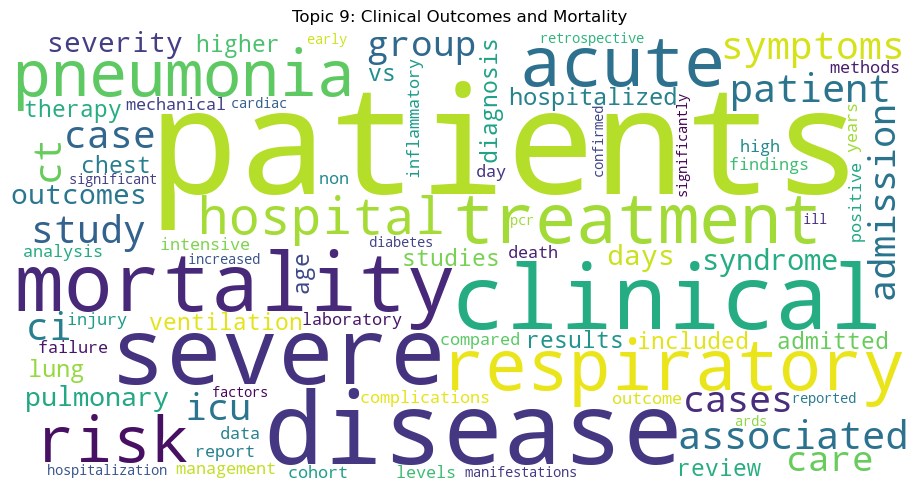

Saved: outputs/wordclouds/topic_3_Epidemic_Modeling_and_Data_Analysis.png


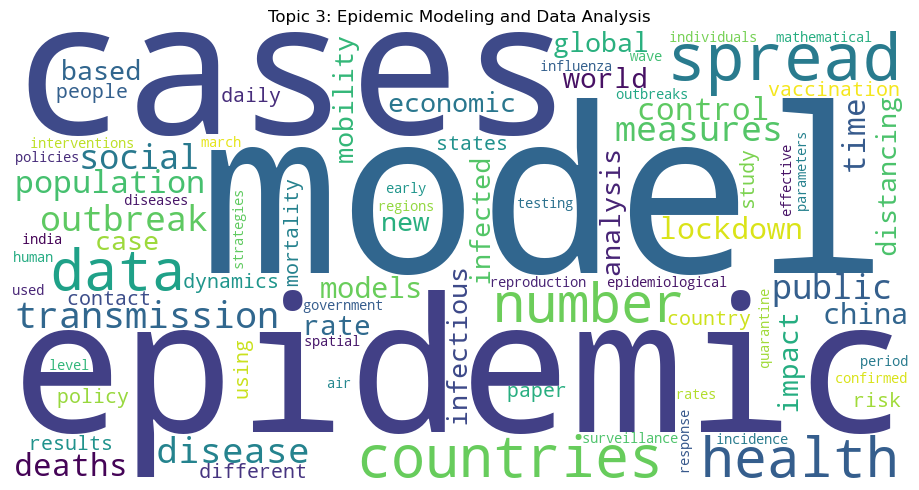

Saved: outputs/wordclouds/topic_18_Vaccination_and_Public_Health_Risk.png


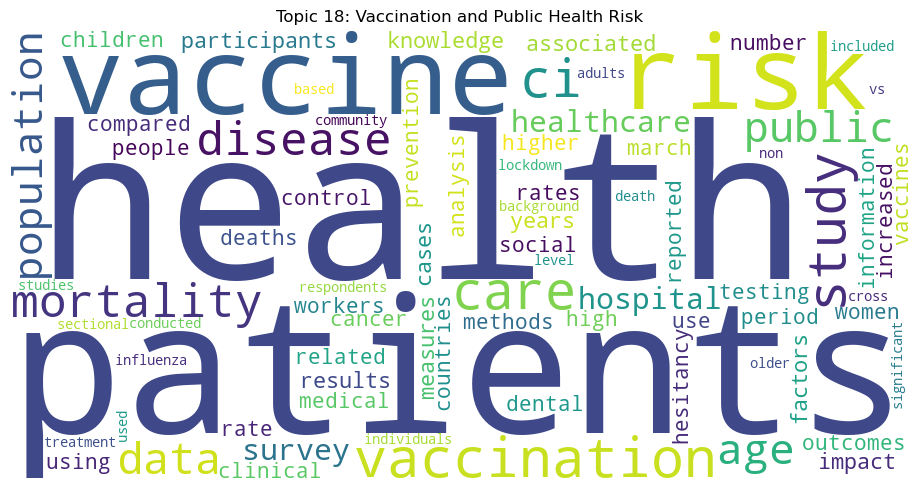

Saved: outputs/wordclouds/topic_14_Mental_Health_and_Psychological_Impact.png


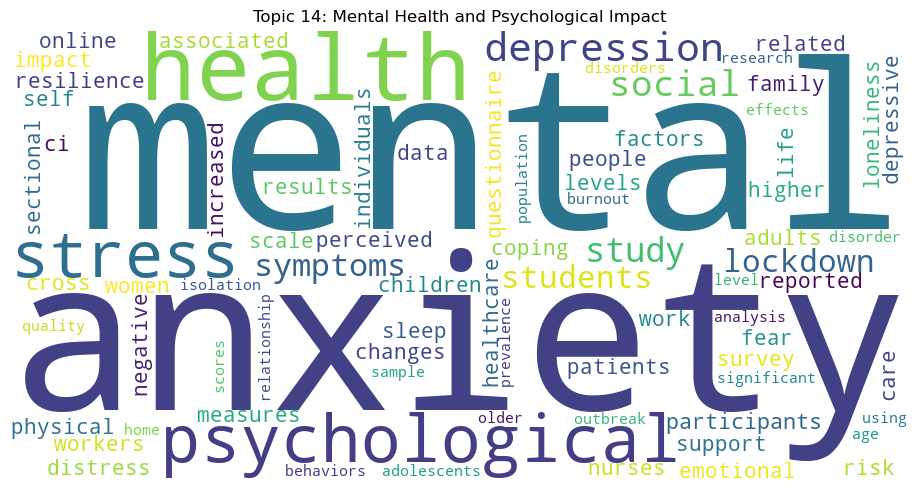

Saved: outputs/wordclouds/topic_4_Public_Health_and_Social_Media.png


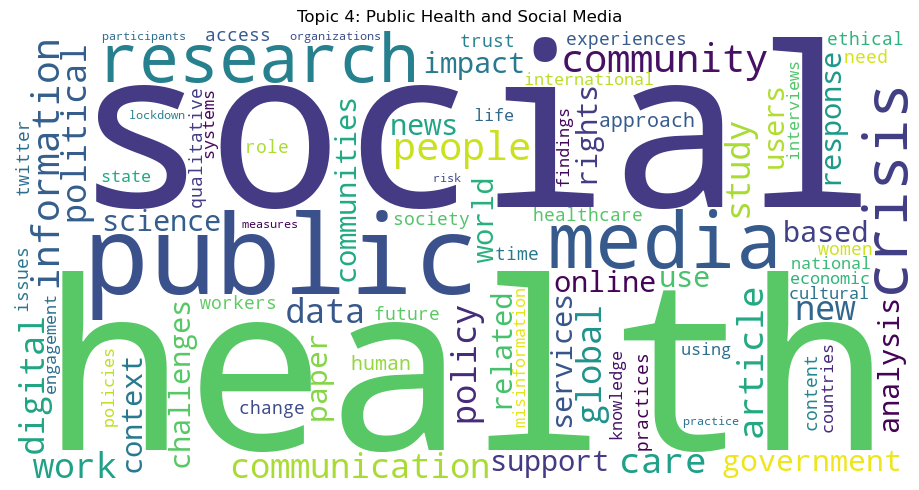

Saved: outputs/wordclouds/topic_11_Viral_Proteins_and_Molecular_Binding.png


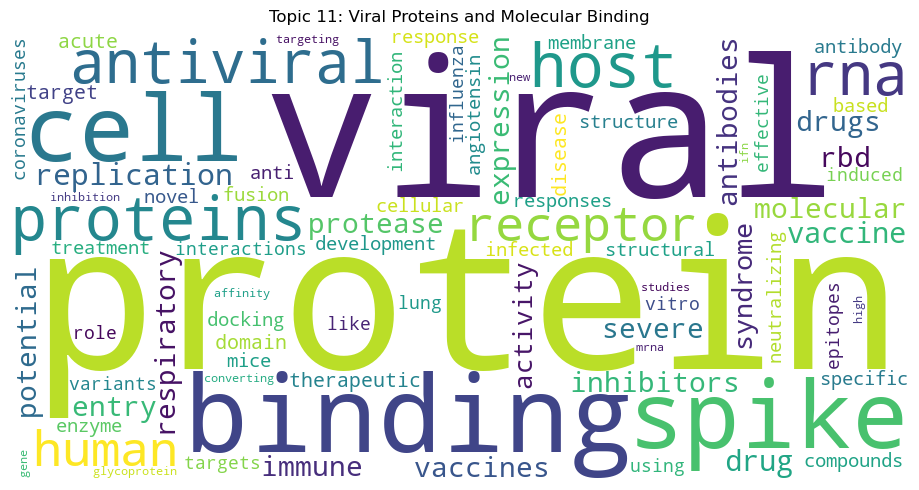

Saved: outputs/wordclouds/topic_0_Telemedicine_and_Healthcare_Delivery.png


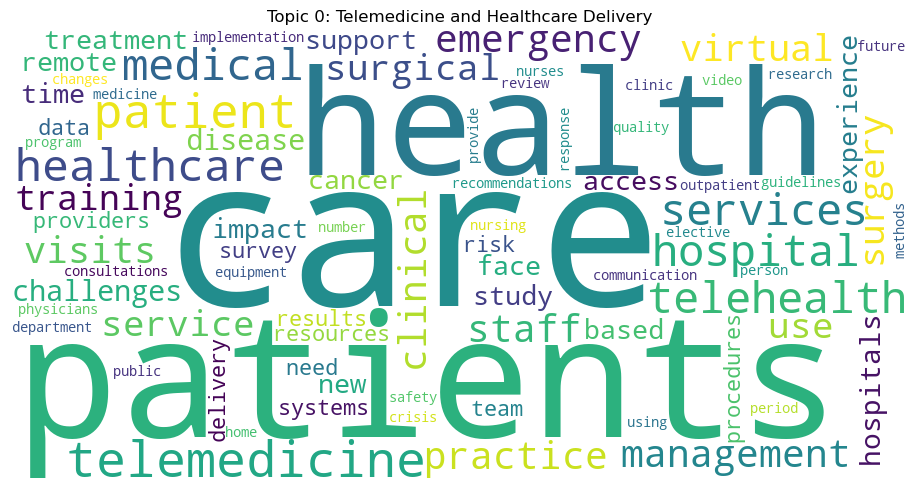

Saved: outputs/wordclouds/topic_5_Clinical_Interventions_and_Patient_Care.png


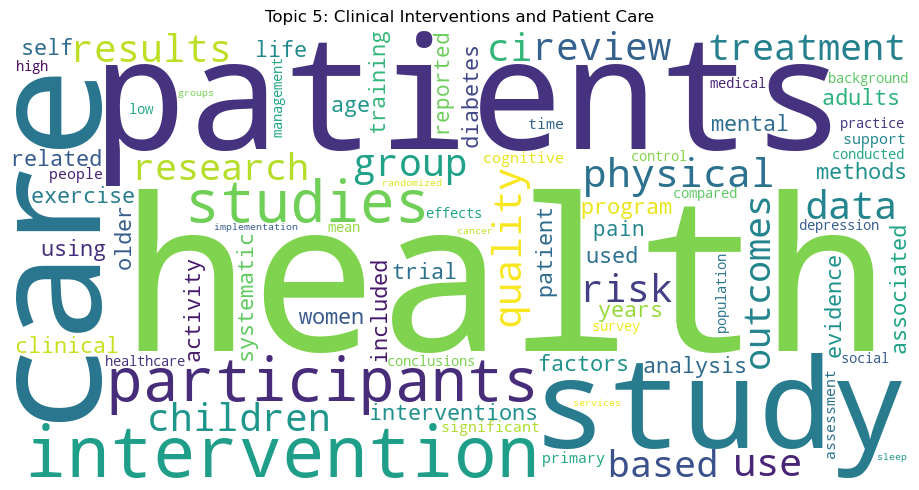

Saved: outputs/wordclouds/topic_7_Immune_Response_and_Inflammation.png


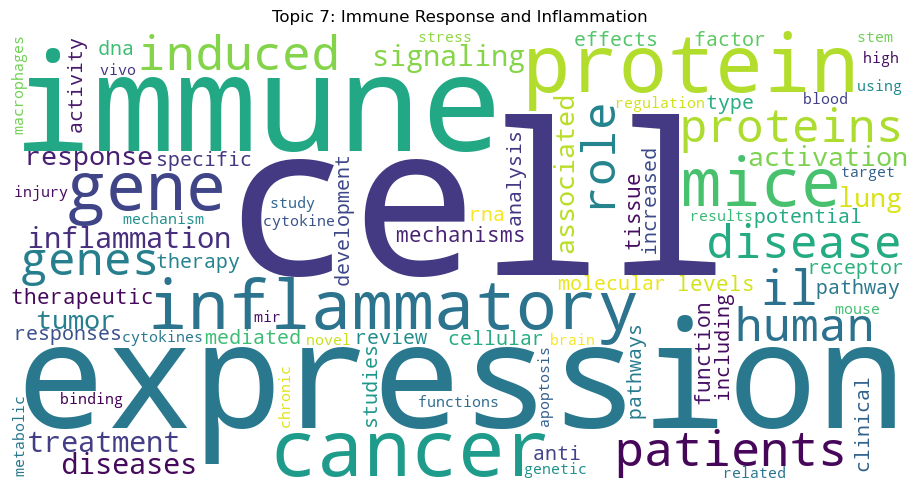

Saved: outputs/wordclouds/topic_2_Acute_Respiratory_Distress_Syndrome.png


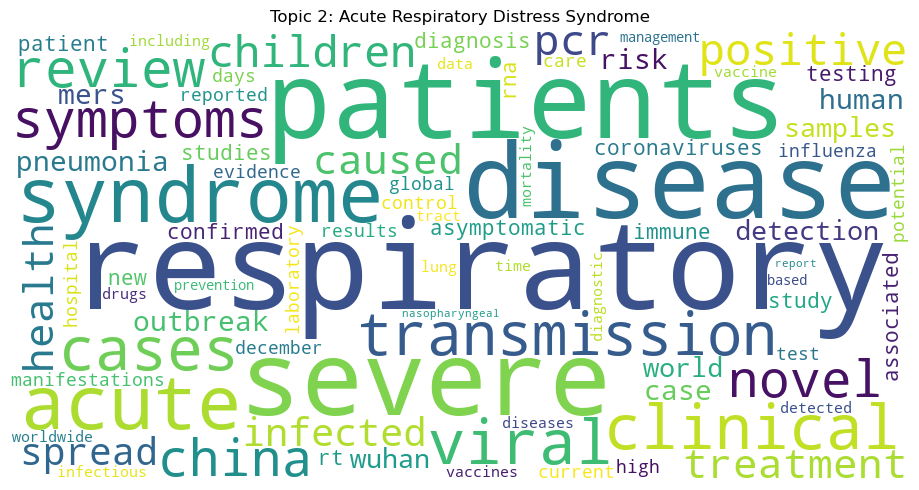

Saved: outputs/wordclouds/topic_10_Economic_Impact_and_Market_Effects.png


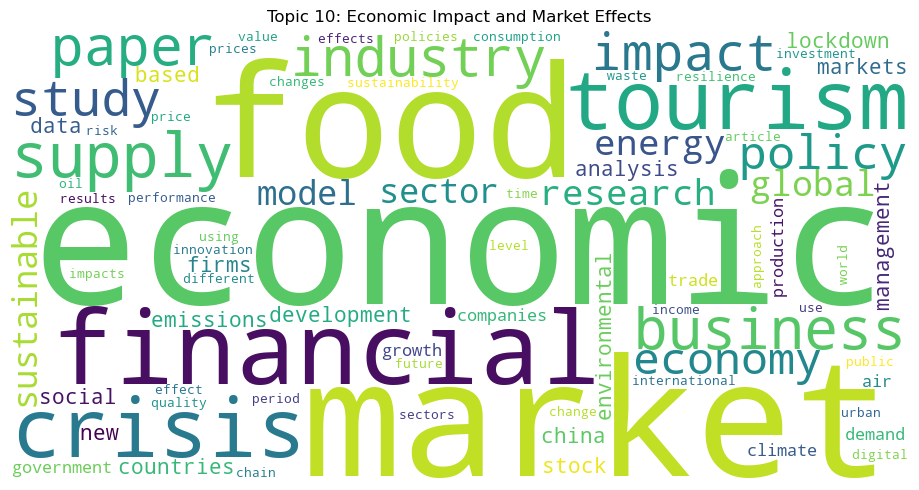

Saved: outputs/wordclouds/topic_15_Vaccine_Development_and_Antibody_Response.png


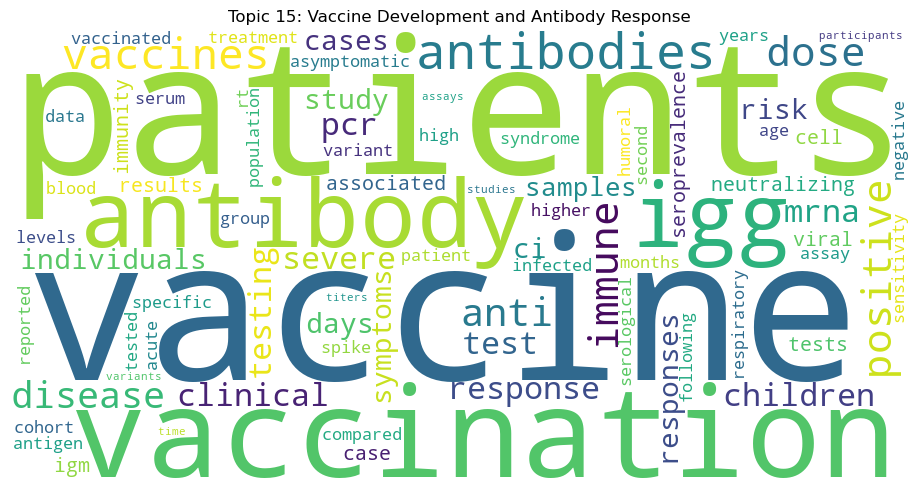

Saved: outputs/wordclouds/topic_19_Infectious_Disease_Pathogens.png


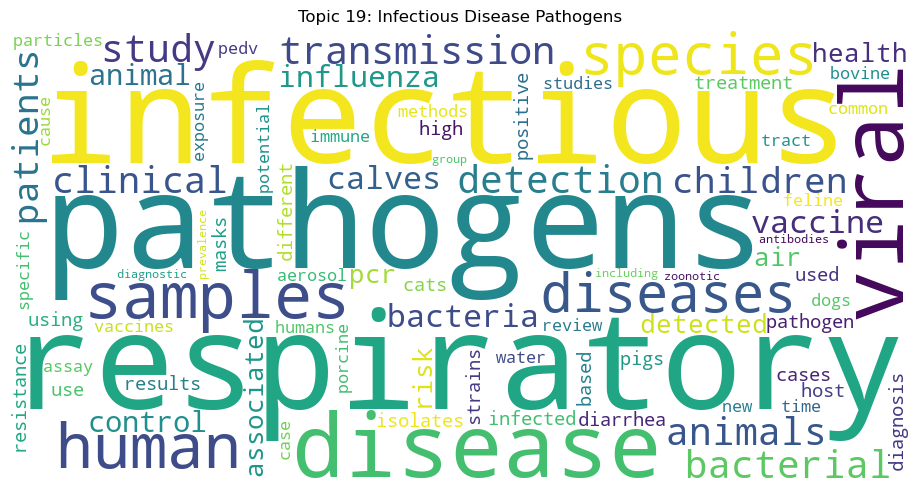

Saved: outputs/wordclouds/topic_8_Research_Methods_and_Social_Studies.png


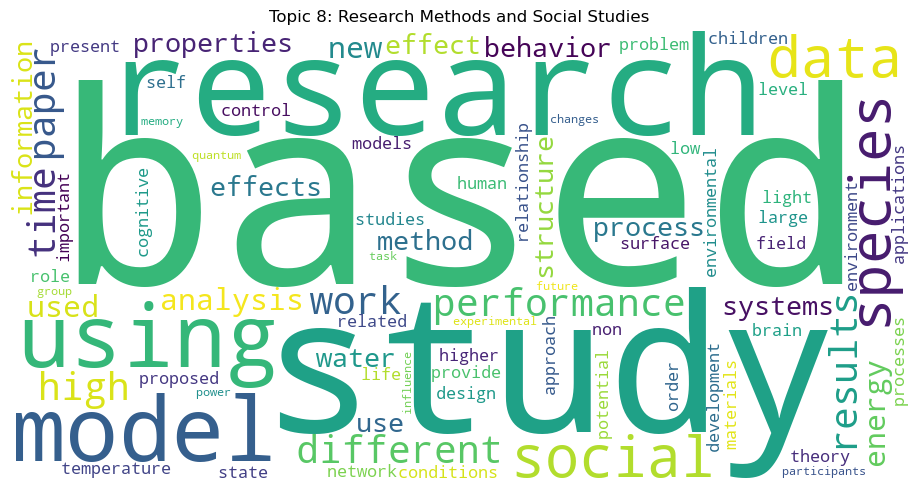

Saved: outputs/wordclouds/topic_17_Clinical_Treatment_and_Stroke_Management.png


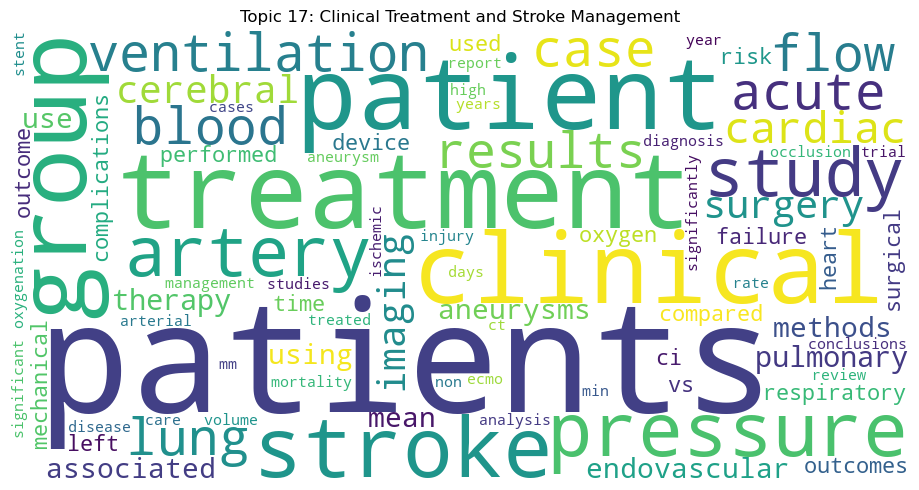

Saved: outputs/wordclouds/topic_12_Online_Education_and_Remote_Learning.png


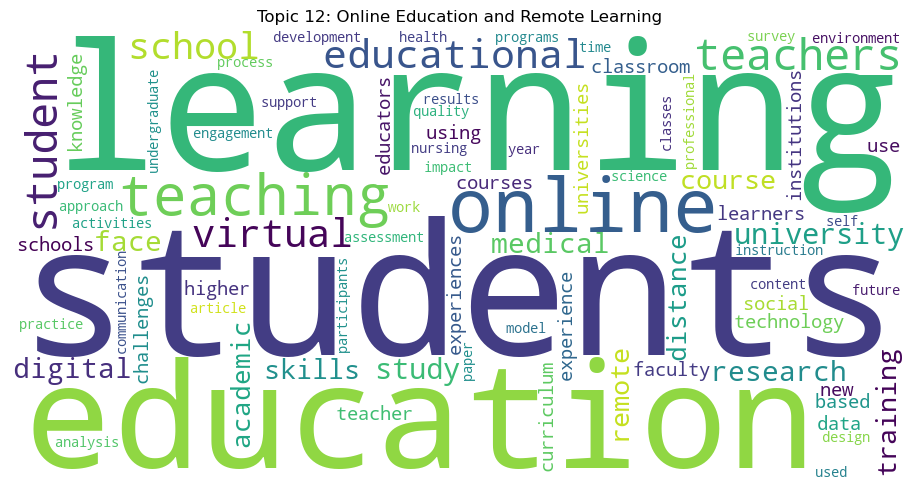

Saved: outputs/wordclouds/topic_1_Drug_Discovery_and_Compound_Activity.png


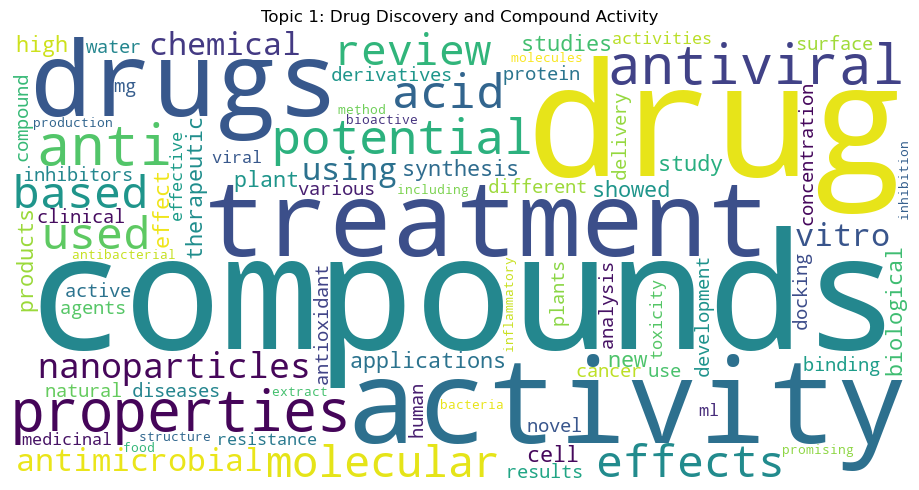

Saved: outputs/wordclouds/topic_16_Machine_Learning_and_Medical_Imaging.png


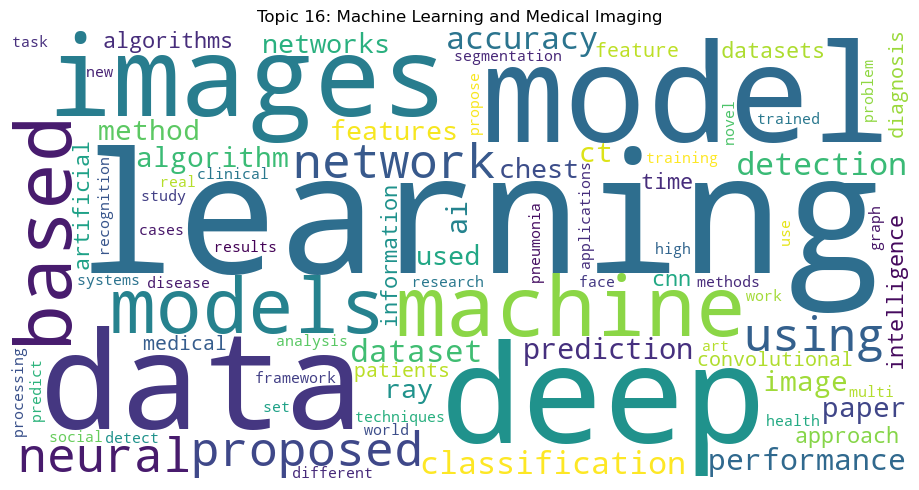

Saved: outputs/wordclouds/topic_13_Surgical_Procedures_and_Postoperative_Care.png


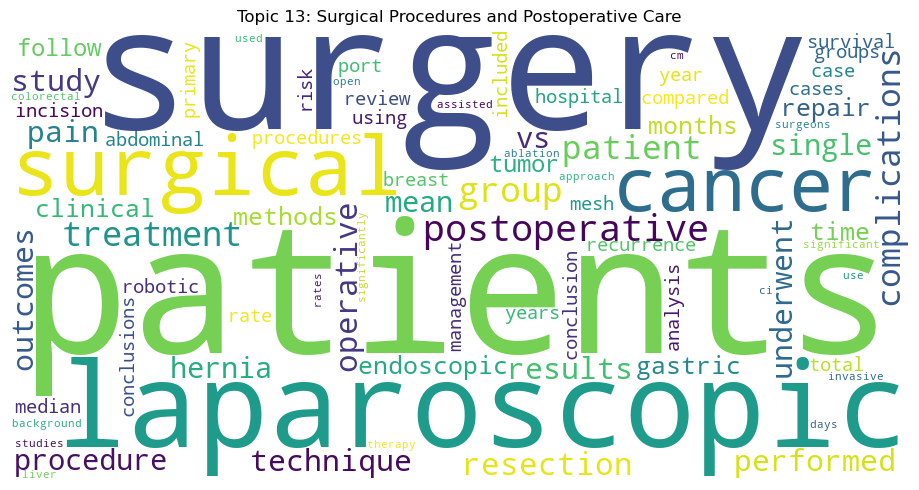

Saved: outputs/wordclouds/topic_6_Viral_Genome_Detection_and_PCR_Testing.png


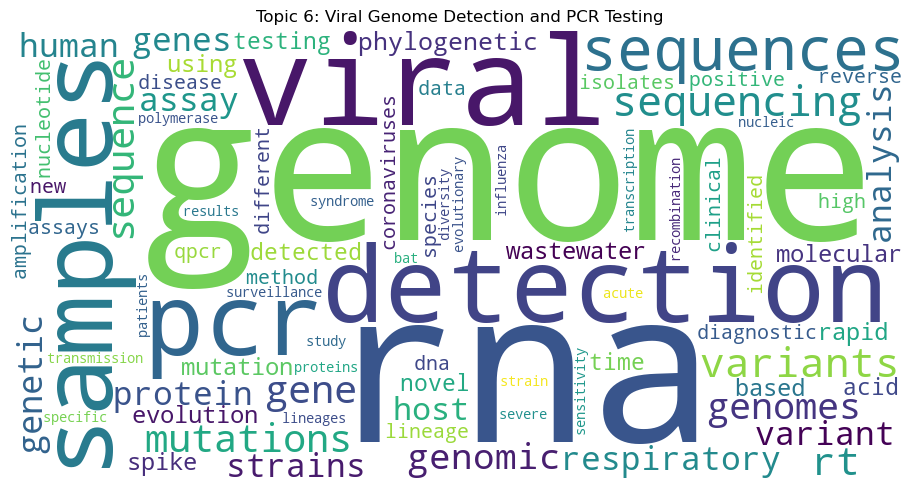

In [82]:
# Create directory to save word clouds
os.makedirs('outputs/wordclouds', exist_ok=True)

def topic_wordcloud(topic_id, max_words=80, save=True):
    mask = (nlp_en["topic"].values == topic_id)
    mean_tfidf = X_tfidf[mask].mean(axis=0).A1
    weights = {}
    for i in mean_tfidf.argsort()[-200:]:
        term = terms[i]
        if term not in generic_terms:
            weights[term] = mean_tfidf[i]
    
    wc = WordCloud(width=900, height=450, background_color="white", max_words=max_words)
    wc.generate_from_frequencies(weights)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    
    topic_label = topic_labels_filtered.get(topic_id, f'Topic {topic_id}')
    plt.title(f"Topic {topic_id}: {topic_label}")
    plt.tight_layout()
    
    if save:
        # Clean filename: remove invalid characters
        clean_label = re.sub(r'[^\w\s-]', '', topic_label) 
        clean_label = clean_label.replace(' ', '_') 
        clean_label = re.sub(r'_+', '_', clean_label)
        
        filename = f"outputs/wordclouds/topic_{topic_id}_{clean_label}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Saved: {filename}")
    
    plt.show()
    plt.close()

# Generate and save word clouds for all top topics
for t in top_topics:
    topic_wordcloud(t, save=True)

In [42]:
nlp_year = nlp_en.dropna(subset=["year"]).copy()
nlp_year["decade"] = (nlp_year["year"] // 10) * 10

In [43]:
topic_decade = (
    nlp_year.groupby(["decade", "topic"])
    .size()
    .reset_index(name="count")
)

In [44]:
topic_decade_pivot = topic_decade.pivot(
    index="decade",
    columns="topic",
    values="count"
).fillna(0)

In [49]:
topic_decade_pivot.head(5)

topic    0     1     2    3    4    5      6      7     8    9    10     11  \
decade                                                                        
1950.0  0.0   0.0   0.0  0.0  0.0  0.0    0.0    0.0   0.0  0.0  0.0    0.0   
1960.0  0.0   0.0   0.0  0.0  0.0  0.0    0.0    2.0   1.0  0.0  0.0    0.0   
1970.0  0.0   4.0   7.0  0.0  0.0  0.0    3.0    4.0   4.0  0.0  0.0   15.0   
1980.0  0.0  21.0   3.0  1.0  0.0  1.0   66.0   59.0   6.0  3.0  0.0  115.0   
1990.0  1.0  67.0  14.0  2.0  0.0  6.0  170.0  177.0  22.0  6.0  0.0  206.0   

topic    12   13   14   15   16    17   18     19  
decade                                             
1950.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0    2.0  
1960.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0    1.0  
1970.0  0.0  0.0  0.0  4.0  0.0   0.0  0.0   56.0  
1980.0  0.0  0.0  0.0  7.0  0.0   6.0  2.0  193.0  
1990.0  0.0  3.0  1.0  9.0  1.0  17.0  2.0  278.0

In [50]:
# Remove 1950 and 1960
topic_decade_pivot = topic_decade_pivot.drop([1950, 1960], errors='ignore')

# Convert index to integers (removes .0)
topic_decade_pivot.index = topic_decade_pivot.index.astype(int)

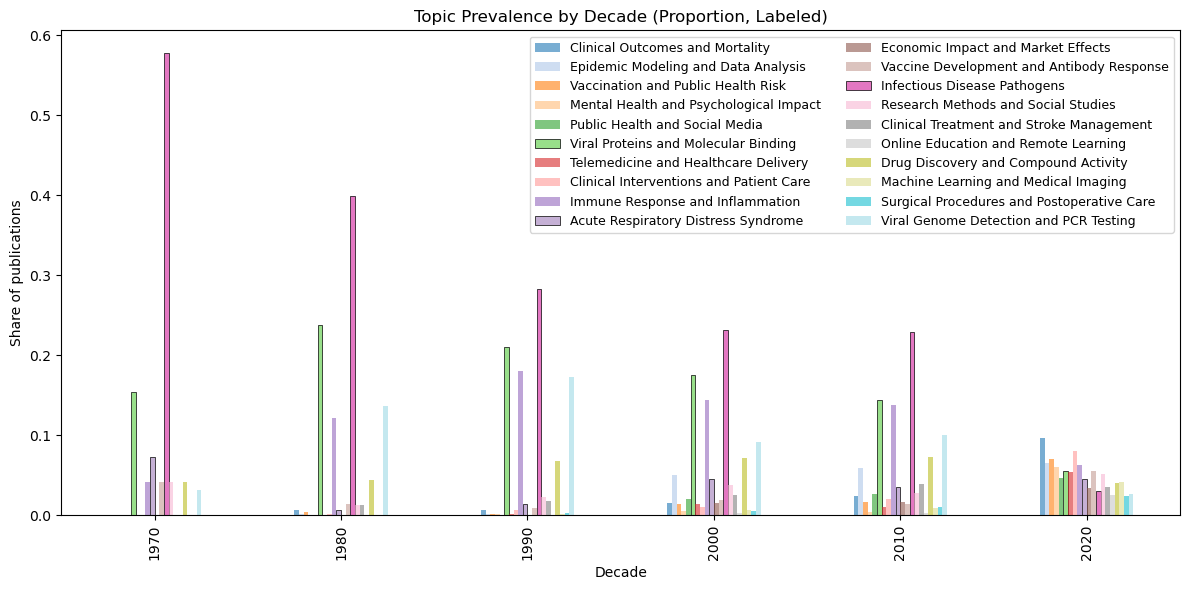

In [81]:
topic_decade_prop = topic_decade_pivot.div(topic_decade_pivot.sum(axis=1), axis=0)
renamer = {t: topic_labels_filtered.get(t, f"Topic {t}") for t in top_topics}

# Find top 3 topics in 1970
top_3_1970 = topic_decade_prop.loc[1970, top_topics].nlargest(3).index.tolist()

colors = cm.tab20(np.linspace(0, 1, 20))
# Create the plot
ax = topic_decade_prop[top_topics].rename(columns=renamer).plot(
    kind="bar", 
    figsize=(12, 6),
    alpha=0.6,
    color=colors
)

# Highlight the top 3 from 1960
for i, container in enumerate(ax.containers):
    topic_id = top_topics[i]
    if topic_id in top_3_1970:
        for patch in container:
            patch.set_alpha(1.0)  # Full opacity for top 3
            patch.set_edgecolor('black')  # Add border
            patch.set_linewidth(0.5)

plt.title("Topic Prevalence by Decade (Proportion, Labeled)")
plt.xlabel("Decade")
plt.ylabel("Share of publications")
plt.legend(ncol=2, loc='best', fontsize=9)
plt.tight_layout()
plt.show()

## Conclusion

The relative frequency of identified topics was analyzed for the period from 1970 to 2020. Although the dataset contains metadata dating back to the 1950s, the number of records before 1970 was too limited to support meaningful analysis and was therefore excluded.

Clear temporal trends were observed, revealing substantial shifts in research focus over time. In the 1970s, research was heavily concentrated on **Topic 19: Infectious Disease Pathogens**, which accounted for more articles than all other topics combined. Research activity during this decade was also limited in scope, with only **8 out of 20 topics** being studied. The second most frequently researched topic was **Topic 11: Viral Proteins and Molecular Binding**, and both topics remained dominant through subsequent decades up to 2020.

From the 1980s onward, **Topic 7: Immune Response and Inflammation** and **Topic 6: Viral Genome Detection and PCR Testing** emerged as the third and fourth most frequently studied topics. These topics gained importance as advances in immunology and molecular biology developed and remained relevant through the 2010s.

Before the 2020s, topics such as **Topic 12: Online Education and Remote Learning** and **Topic 4: Public Health and Social Media** were not present in the dataset. This is expected, as these topics are closely linked to recent technological developments and the societal impacts of the COVID-19 pandemic.

In the 2020s, research topics became more evenly distributed overall. However, a stronger focus remained on **Topic 9: Clinical Outcomes and Mortality**, **Topic 5: Clinical Interventions and Patient Care**, and **Topic 18: Vaccination and Public Health Risk**.

Overall, the results show a clear evolution of research priorities, shifting from a narrow focus on pathogens and viral mechanisms in earlier decades to a broader, more clinically and socially oriented research landscape in response to modern global health challenges.
